# Project 4: Predict West Nile Virus
### Section 4. EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [92]:
#!pip install shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math

## Load Data

In [32]:
# Load datasets
df = pd.read_csv('../data/combined.csv', index_col='Unnamed: 0')

In [33]:
# drop duplicated columns for year, month, week and day of week
df.drop(['year_y', 'month_y', 'week_y', 'dayofweek_y'], axis=1, inplace=True)

In [34]:
# rename unduplicated columns for year, month, week and day of week
df.rename(
    columns={
        "year_x": "year", 
        "month_x": "month",
        "week_x": "week",
        "dayofweek_x": "dayofweek",
    },
    inplace=True
)

In [35]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train']
test = df[df['dataset']=='test']
print(train.shape)
print(test.shape)

(8304, 35)
(43035, 35)


In [36]:
train.head()

,dataset,date,species,trap,latitude,longitude,wnvpresent,year,month,week,...,sunset,codesum,depth,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,is_spray
0,train,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0.0,2007,5,22,...,1917,BR HZ,0,0.0,29.39,30.11,5.8,18,6.5,0.0
1,train,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,0.0,2007,5,22,...,1917,BR HZ,0,0.0,29.39,30.11,5.8,18,6.5,0.0
2,train,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,0.0,2007,5,22,...,1917,BR HZ,0,0.0,29.39,30.11,5.8,18,6.5,0.0
3,train,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,0.0,2007,5,22,...,1917,BR HZ,0,0.0,29.39,30.11,5.8,18,6.5,0.0
4,train,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,0.0,2007,5,22,...,1917,BR HZ,0,0.0,29.39,30.11,5.8,18,6.5,0.0


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dataset       8304 non-null   object 
 1   date          8304 non-null   object 
 2   species       8304 non-null   object 
 3   trap          8304 non-null   object 
 4   latitude      8304 non-null   float64
 5   longitude     8304 non-null   float64
 6   wnvpresent    8304 non-null   float64
 7   year          8304 non-null   int64  
 8   month         8304 non-null   int64  
 9   week          8304 non-null   int64  
 10  dayofweek     8304 non-null   int64  
 11  nummosquitos  8304 non-null   float64
 12  dist_s1       8304 non-null   float64
 13  dist_s2       8304 non-null   float64
 14  nearest_stat  8304 non-null   int64  
 15  station       8304 non-null   int64  
 16  tmax          8304 non-null   int64  
 17  tmin          8304 non-null   int64  
 18  tavg          8304 non-null 

In [77]:
train.columns

Index(['dataset', 'date', 'species', 'trap', 'latitude', 'longitude',
       'wnvpresent', 'year', 'month', 'week', 'dayofweek', 'nummosquitos',
       'dist_s1', 'dist_s2', 'nearest_stat', 'station', 'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
       'codesum', 'depth', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'is_spray'],
      dtype='object')

## EDA

In [82]:
# Numeric variables
numeric_features = ['latitude', 'longitude',
       'year', 'month', 'week', 'dayofweek', 'nummosquitos',
       'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset',
       'depth', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'is_spray'
]

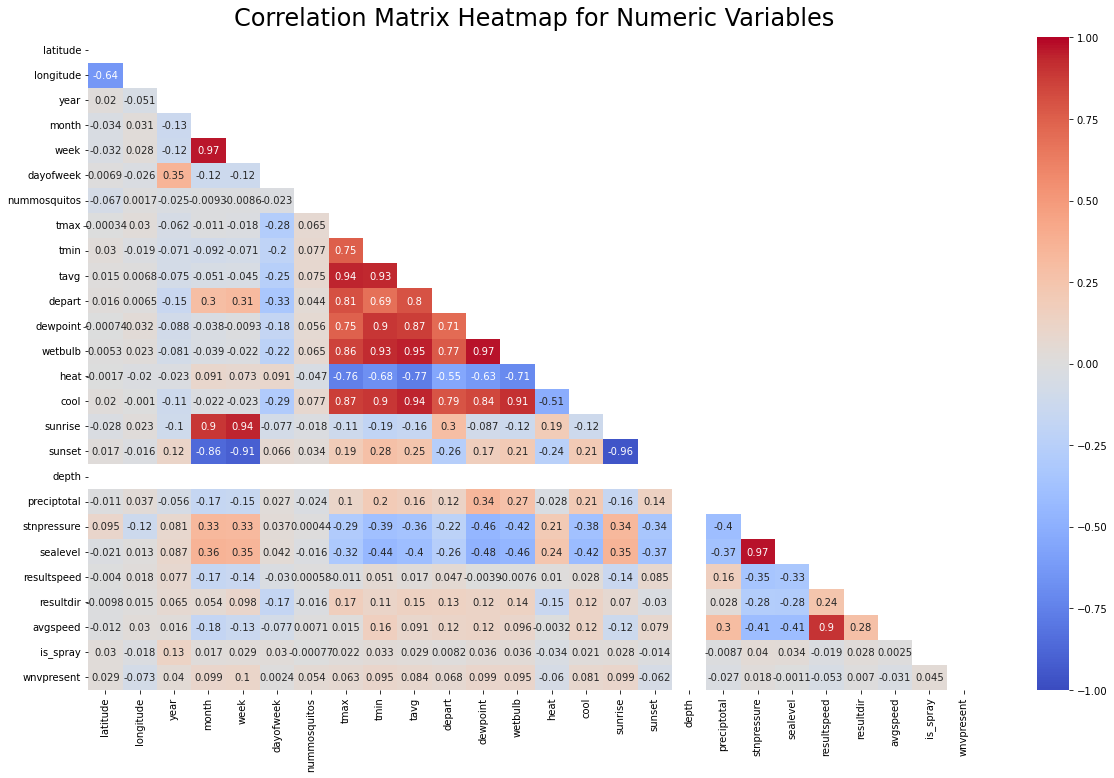

In [94]:
# take a look at the correlation of the numeric features with wnv and collinearity
plt.figure(figsize=(20,12))
mask = np.triu(np.ones_like(train[numeric_features + ['wnvpresent']].corr(), dtype=bool))
corr_matrix = sns.heatmap(train[numeric_features + ['wnvpresent']].corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Numeric Variables', fontdict={'fontsize':24}, pad=12);

- Based on correlation matrix and distribution, some features have severe multicollinearity (i.e. correlation >0.8) and have distributions which look similar, so they should not be concurrently added in the model. We will drop one of these features:
    - avgspeed and resultspeed (drop resultspeed): average wind speed and resultant wind speed
    - stnpressure and sealevel (drop sealevel): average station pressure and average sea level pressure
    -  sunrise and sunset (drop sunset): timing of sunrise and sunset
    - cool, wetbulb and dewpoint (drop wetbulb and dewpoint): cooling (season begins with Jan), wet-bulb temperature (the lowest temperature that can be reached under current ambient conditions by the evaporation of water only) and dewpoint (temperature to which air needs to be cooled to in order to achieve a relative humidity of 100%) as these are all measures related to lowering temperature
    - tavg, cool, wetbulb, dewpoint, depart (drop cool and depart): cooling (season begins with Jan) and depart (average temperatures above or below the 30-year normal) can be dropped as well as average temperature in Degrees Fahrenheit would account for these measurements
    - tavg, tmax and tmin (drop tmin and tmax): min and max temperature in Degrees Fahrenheit can be dropped as both are accounted for in the average temperature in Degrees Fahrenheit
    - week, sunrise and sunset (drop sunrise): in addition to dropping sunset (which is correlated to sunrise), sunrise can be dropped as this is strongly correlated with the week of the year
    - week and month (drop month): as week has higher resolution and provides more information than month, we drop month

In [97]:
# Filter out numeric features with severe multicollinearity (i.e. correlation >0.8) - to be used in model
numeric_features = ['latitude', 'longitude',
       'year', 'week', 'dayofweek', 'nummosquitos',
       'tavg', 'heat',
       'preciptotal', 'stnpressure',
       'resultdir', 'avgspeed', 'is_spray'
]

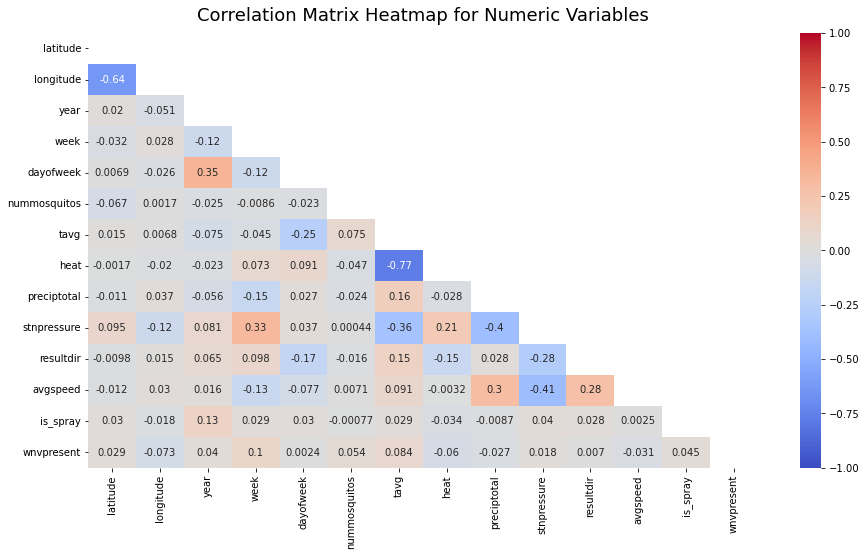

In [128]:
# take a look at the correlation of the filtered numeric features with wnv and collinearity
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(train[numeric_features + ['wnvpresent']].corr(), dtype=bool))
corr_matrix = sns.heatmap(train[numeric_features + ['wnvpresent']].corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Numeric Variables', fontdict={'fontsize':18}, pad=12);

- wnvpresent is not strongly correlated with location, in terms of longitude and latitude, time of year and weather
- Amongst all numeric features, wnvpresent is most correlated with week of the year, followed by tavg, number of mosquitoes and whether spray is provided

In [101]:
train[numeric_features + ['wnvpresent']].corr().sort_values('wnvpresent', ascending=False)['wnvpresent']

wnvpresent      1.000000
week            0.101697
tavg            0.083612
nummosquitos    0.054205
is_spray        0.044545
year            0.040257
latitude        0.028507
stnpressure     0.018014
resultdir       0.007003
dayofweek       0.002382
preciptotal    -0.027474
avgspeed       -0.031341
heat           -0.059806
longitude      -0.073100
Name: wnvpresent, dtype: float64

In [61]:
# create a function to create dataframe to hold dummies for specified categorical features and wnv
def dummies_wnv_df(colname):
    dummies_df = train[[colname]]
    dummies_df = pd.get_dummies(dummies_df)
    dummy_plus_wnvpresent = pd.concat(objs = [dummies_df, train[['wnvpresent']]] , axis = 1)
    return dummy_plus_wnvpresent

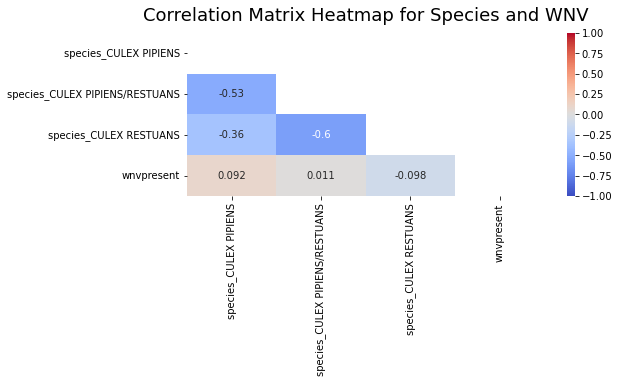

In [121]:
# Look at the correlation of species with wnv
species_wnvpresent = dummies_wnv_df('species')
corr_wnvpresent = species_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(8,3))
mask = np.triu(np.ones_like(species_wnvpresent.corr(), dtype=bool))
corr_matrix = sns.heatmap(species_wnvpresent.corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Species and WNV', fontdict={'fontsize':18}, pad=12);

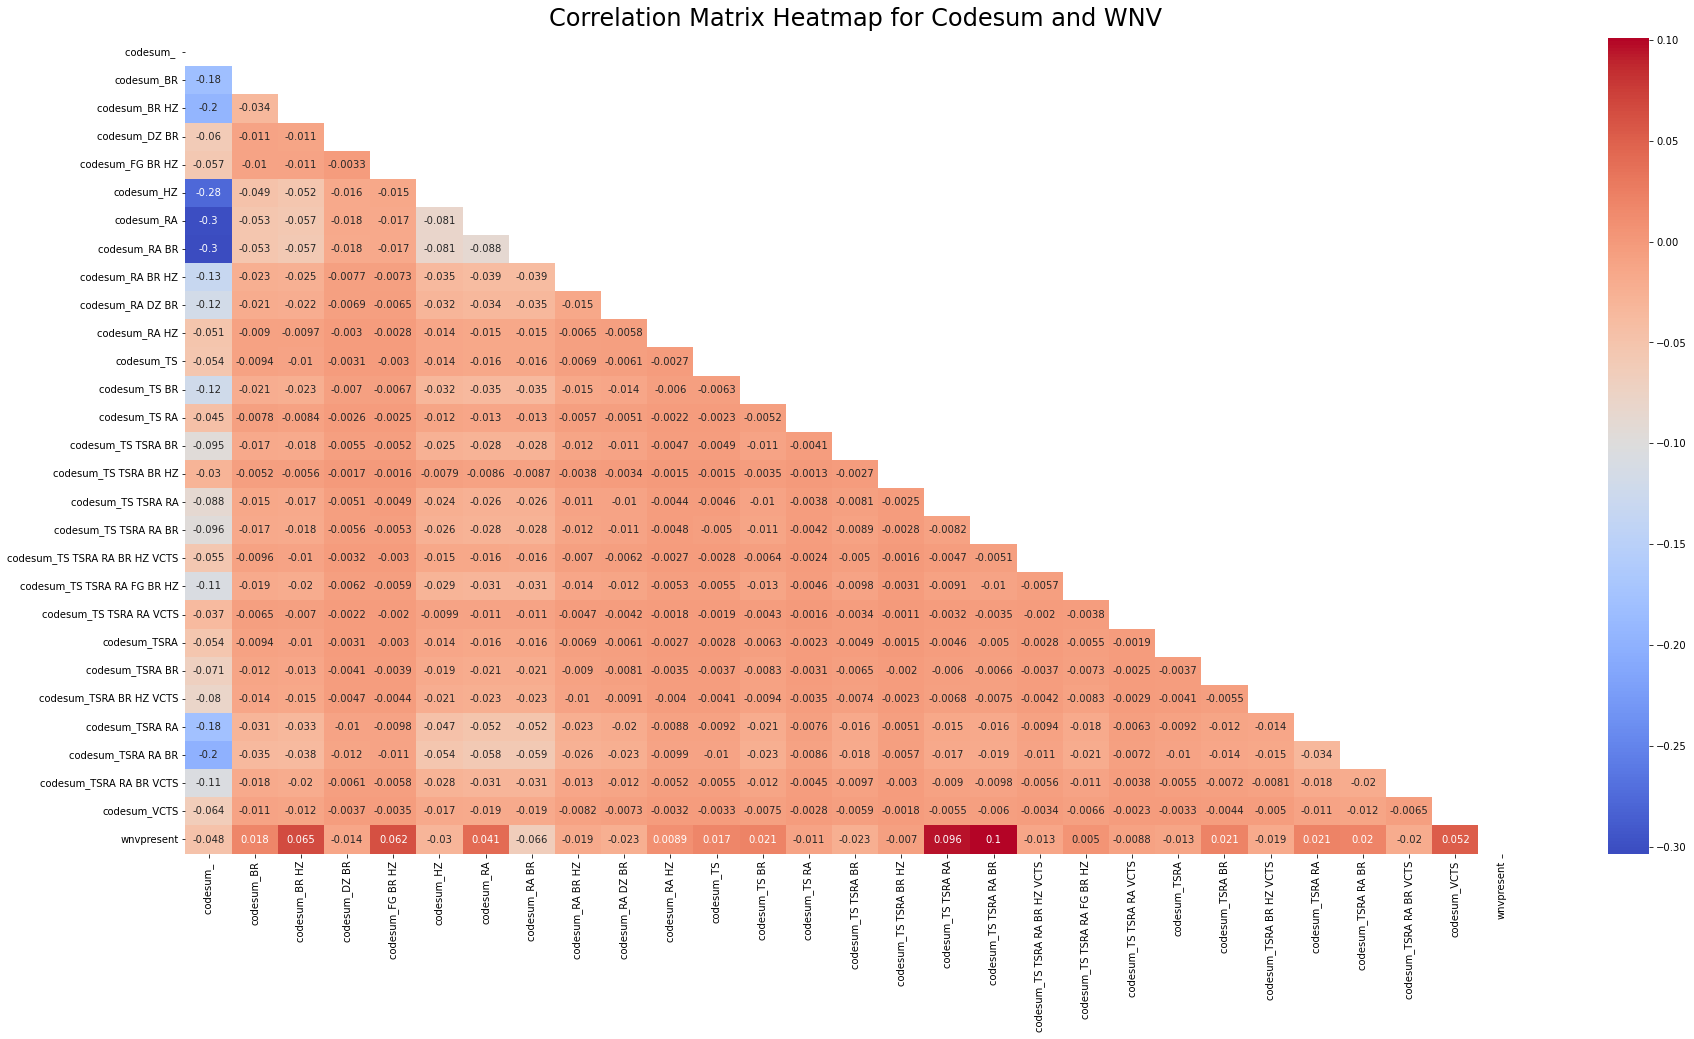

In [123]:
# Look at the correlation of codesum with wnv
codesum_wnvpresent = dummies_wnv_df('codesum')
corr_wnvpresent = codesum_wnvpresent.corr().sort_values('wnvpresent', ascending=False)

plt.figure(figsize=(30,15))
mask = np.triu(np.ones_like(codesum_wnvpresent.corr(), dtype=bool))
corr_matrix = sns.heatmap(codesum_wnvpresent.corr(), mask=mask, annot=True, cmap='coolwarm')
corr_matrix.set_title('Correlation Matrix Heatmap for Codesum and WNV', fontdict={'fontsize':24}, pad=12);

- Presence of WNV is more correlated with:
    - TS TSRA RA BR (Thunderstorm, Thunderstorm & Rain, Rain, Mist) and 
    - TS TSRA RA (Thunderstorm, Thunderstorm & Rain, Rain)

In [127]:
codesum_wnvpresent.corr().sort_values('wnvpresent', ascending=False)['wnvpresent']

wnvpresent                       1.000000
codesum_TS TSRA RA BR            0.100735
codesum_TS TSRA RA               0.095621
codesum_BR HZ                    0.064683
codesum_FG BR HZ                 0.062092
codesum_VCTS                     0.051904
codesum_RA                       0.040965
codesum_TSRA BR                  0.021345
codesum_TS BR                    0.020770
codesum_TSRA RA                  0.020549
codesum_TSRA RA BR               0.019514
codesum_BR                       0.018262
codesum_TS                       0.017425
codesum_RA HZ                    0.008877
codesum_TS TSRA RA FG BR HZ      0.005031
codesum_TS TSRA BR HZ           -0.007010
codesum_TS TSRA RA VCTS         -0.008789
codesum_TS RA                   -0.010603
codesum_TSRA                    -0.012718
codesum_TS TSRA RA BR HZ VCTS   -0.012993
codesum_DZ BR                   -0.014286
codesum_TSRA BR HZ VCTS         -0.018971
codesum_RA BR HZ                -0.018980
codesum_TSRA RA BR VCTS         -0

## Feature Engineering

In [53]:
# Categorical variables
non_numeric_features = [
    'species',
    'trap',
    'codesum'
]

In [54]:
# Create a new dataframe to hold dummies for all categorical features and wnv
dummies_df = train[non_numeric_features]
dummies_df = pd.get_dummies(dummies_df, drop_first=True)
dummy_plus_wnvpresent = pd.concat(objs = [dummies_df, train[['wnvpresent']]] , axis = 1)